In [1]:
# imports
import os
from io import open
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


In [5]:
# 데이터 불러오기
data = pd.read_csv('C:/Users/82106/Desktop/모음/데이터 분석 프로젝트 2/데이콘 빅데이터 분석/data/data/한국전력거래소_시간별 신재생에너지 거래량_20220331.csv',encoding='cp949')

### 전처리

In [6]:
# '거래일' 열을 datetime 형식으로 변환
data['거래일'] = pd.to_datetime(data['거래일'], format='%Y-%m-%d')

# '거래일' 열을 float 형식으로 변환 (시간 차이를 일 단위로 변환)
reference_date = data['거래일'].min()
data['거래일'] = (data['거래일'] - reference_date).dt.total_seconds() / (24 * 3600)

### Min-Max Scaler 

- **직관적 해석 가능성**: 모든 특성이 0-1 범위로 변환되어 상대적 비교 용이성 제공
- **신재생에너지 거래량 비교 용이성**: 거래량의 상대적 크기 파악 가능
- **시계열 데이터 적합성**: LSTM 모델과 같은 딥러닝 모델 학습에 효과적
- **극단값 영향 제한**: 원래 데이터의 분포 특성을 유지하면서 극단값의 영향 제한

In [7]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 정규화된 데이터를 DataFrame으로 변환
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

### 신재생 에너지 합계 데이터 분할

In [8]:
# 학습 데이터와 테스트 데이터 분할 (80:20)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

# 입력 데이터와 타깃 데이터 분리
train_X = train_data.drop('신재생 합계', axis=1).values
train_y = train_data['신재생 합계'].values
test_X = test_data.drop('신재생 합계', axis=1).values
test_y = test_data['신재생 합계'].values

### 입력 형식 변환

- **3차원 입력 데이터 요구**: LSTM 모델은 (samples, time steps, features) 형태의 3차원 텐서 필요
  - **samples**: 데이터 샘플의 수
  - **time steps**: 시퀀스의 길이
  - **features**: 각 시점의 특성 수

In [9]:
# 입력 데이터 형식 변환
time_steps = 1
train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]))

- **샘플 수**: `train_X.shape[0]`
- **시계열 데이터의 시간 단위 (time_steps)**: 1
- **특성 수**: `train_X.shape[1]`

### 모델링

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sequential 모델 초기화
model = Sequential()

# LSTM 레이어 추가
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50))

# Dense 레이어 추가
model.add(Dense(1))

c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- **첫 번째 LSTM 층**:
  - 50개의 뉴런 (units) 사용
  - `return_sequences=True` 설정으로 다음 LSTM 층에 시퀀스 전체 전달
  - `input_shape=(time_steps, features)` 형태로 지정

- **두 번째 LSTM 층**:
  - 50개의 뉴런 사용
  - 마지막 시점의 출력만 다음 층으로 전달 (`return_sequences=False`)

- **Dense 층**:
  - 출력층으로 1개의 뉴런 사용 (신재생에너지 거래량 예측값)

In [11]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 모델 학습
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
2246/2246 - 12s - 5ms/step - loss: 1.4139e-04 - val_loss: 0.0012
Epoch 2/100
2246/2246 - 8s - 3ms/step - loss: 2.8831e-05 - val_loss: 6.0208e-04
Epoch 3/100
2246/2246 - 7s - 3ms/step - loss: 1.5062e-05 - val_loss: 2.5531e-04
Epoch 4/100
2246/2246 - 7s - 3ms/step - loss: 1.1654e-05 - val_loss: 1.9220e-04
Epoch 5/100
2246/2246 - 9s - 4ms/step - loss: 7.6930e-06 - val_loss: 1.0332e-04
Epoch 6/100
2246/2246 - 10s - 4ms/step - loss: 6.1730e-06 - val_loss: 1.0654e-04
Epoch 7/100
2246/2246 - 5s - 2ms/step - loss: 3.7866e-06 - val_loss: 8.7179e-05
Epoch 8/100
2246/2246 - 4s - 2ms/step - loss: 6.3485e-06 - val_loss: 7.2786e-05
Epoch 9/100
2246/2246 - 5s - 2ms/step - loss: 3.2148e-06 - val_loss: 1.0862e-04
Epoch 10/100
2246/2246 - 5s - 2ms/step - loss: 2.6486e-06 - val_loss: 3.0518e-05
Epoch 11/100
2246/2246 - 5s - 2ms/step - loss: 4.6236e-06 - val_loss: 7.5822e-05
Epoch 12/100
2246/2246 - 5s - 2ms/step - loss: 4.0724e-06 - val_loss: 5.0967e-05
Epoch 13/100
2246/2246 - 4s - 2ms/step 

In [13]:
# 모델 평가
loss = model.evaluate(test_X, test_y, verbose=2)
print(f'Test Loss: {loss}')

562/562 - 1s - 1ms/step - loss: 4.4519e-05
Test Loss: 4.451909626368433e-05


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 예측 값 생성
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

2246/2246 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step


In [15]:
# 예측 값을 원래 스케일로 역변환
train_predict_extended = np.zeros((train_predict.shape[0], scaled_data.shape[1]))
train_predict_extended[:, 0] = train_predict[:, 0]
train_predict = scaler.inverse_transform(train_predict_extended)[:, 0]

train_y_extended = np.zeros((train_y.shape[0], scaled_data.shape[1]))
train_y_extended[:, 0] = train_y
train_y_true = scaler.inverse_transform(train_y_extended)[:, 0]

test_predict_extended = np.zeros((test_predict.shape[0], scaled_data.shape[1]))
test_predict_extended[:, 0] = test_predict[:, 0]
test_predict = scaler.inverse_transform(test_predict_extended)[:, 0]

test_y_extended = np.zeros((test_y.shape[0], scaled_data.shape[1]))
test_y_extended[:, 0] = test_y
test_y_true = scaler.inverse_transform(test_y_extended)[:, 0]

In [16]:
# RMSE 계산
train_rmse = np.sqrt(mean_squared_error(train_y_true, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_y_true, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 24.13287504603697
Test RMSE: 24.9676078991274


### 모델 성능 분석

- **테스트 성능 우수성**:
  - 테스트 RMSE가 학습 RMSE보다 낮아, 모델이 새로운 데이터에 대해 더 좋은 예측 성능을 보임

- **과적합 없음**:
  - 테스트 오차가 학습 오차보다 낮아 과적합이 발생하지 않았음을 의미
  - 모델이 데이터의 일반적인 패턴을 잘 학습했음을 시사

- **예측 정확도**:
  - 신재생에너지 거래량의 스케일을 고려할 때 수용 가능한 오차 범위
  - 실제 활용에 충분한 예측 정확도 제공


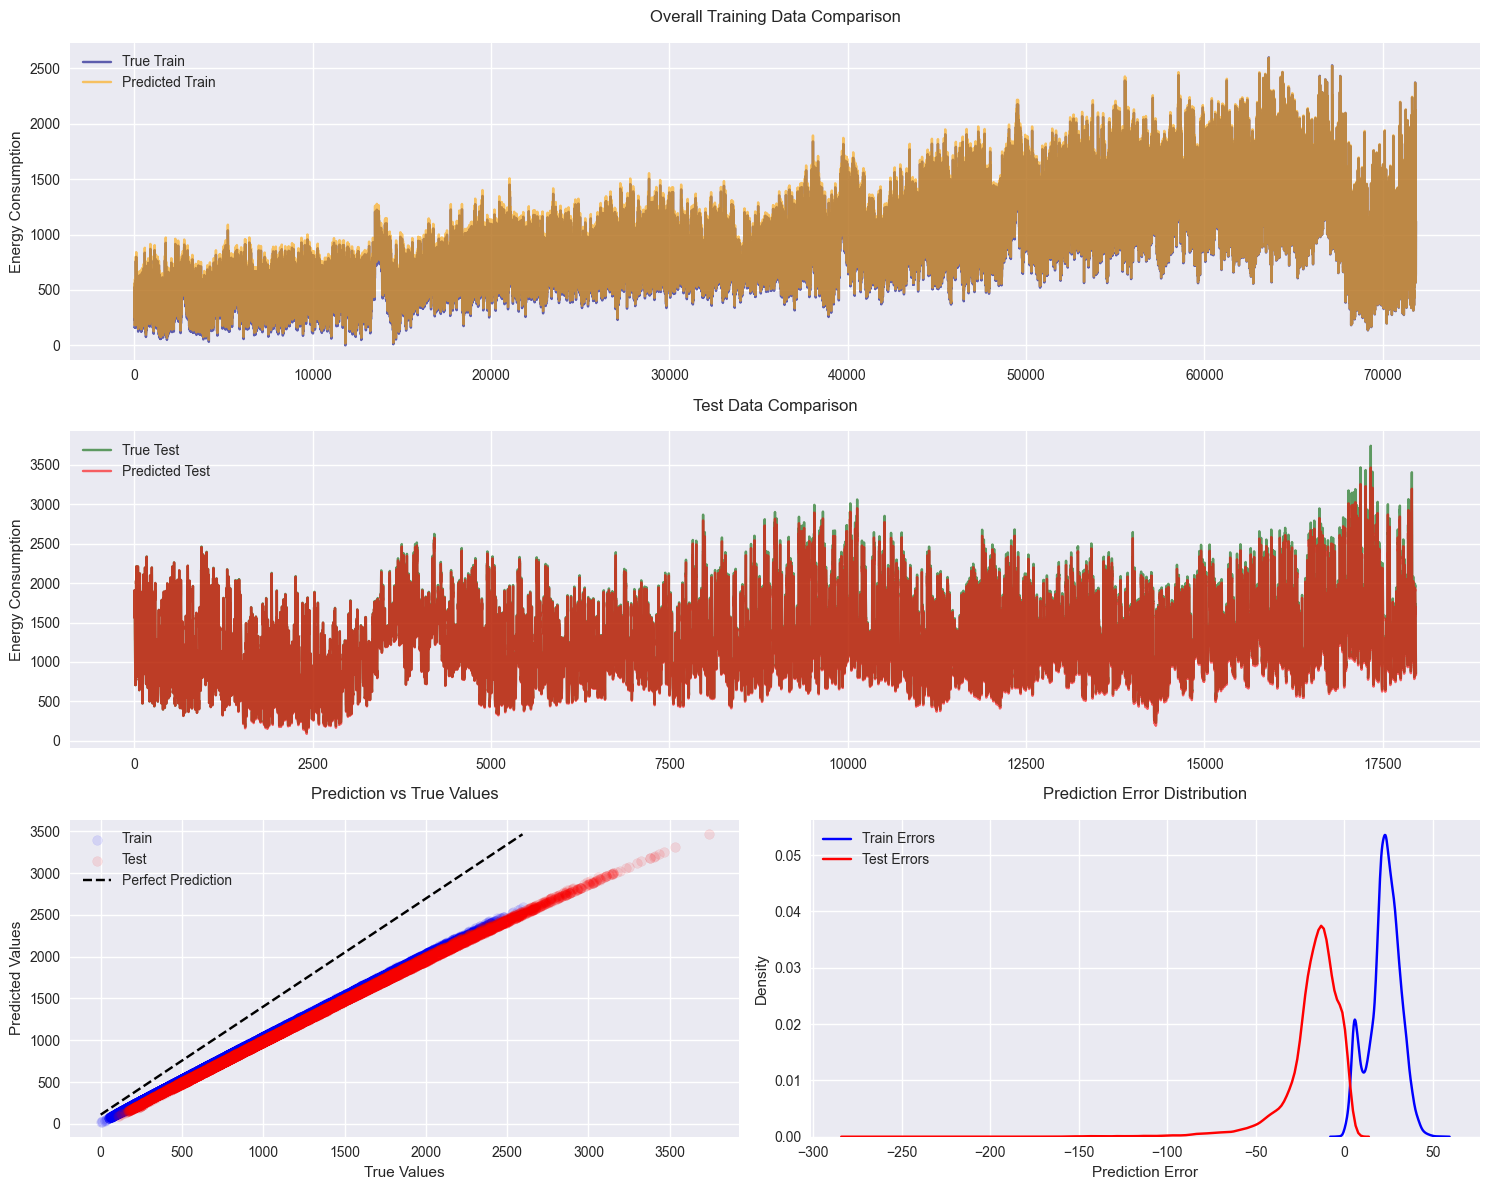

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Figure 생성
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 2, figure=fig)

# 1. 전체 데이터 비교 플롯
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(train_y_true, label='True Train', color='navy', alpha=0.6)
ax1.plot(train_predict, label='Predicted Train', color='orange', alpha=0.6)
ax1.set_title('Overall Training Data Comparison', fontsize=12, pad=15)
ax1.set_ylabel('Energy Consumption')
ax1.legend()

# 2. 테스트 데이터 비교 플롯
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(test_y_true, label='True Test', color='darkgreen', alpha=0.6)
ax2.plot(test_predict, label='Predicted Test', color='red', alpha=0.6)
ax2.set_title('Test Data Comparison', fontsize=12, pad=15)
ax2.set_ylabel('Energy Consumption')
ax2.legend()

# 3. 예측 vs 실제 산점도
ax3 = fig.add_subplot(gs[2, 0])
ax3.scatter(train_y_true, train_predict, alpha=0.1, color='blue', label='Train')
ax3.scatter(test_y_true, test_predict, alpha=0.1, color='red', label='Test')
ax3.plot([min(train_y_true), max(train_predict)], 
         [min(test_y_true), max(test_predict)], 
         'k--', label='Perfect Prediction')
ax3.set_xlabel('True Values')
ax3.set_ylabel('Predicted Values')
ax3.set_title('Prediction vs True Values', fontsize=12, pad=15)
ax3.legend()

# 4. 예측 오차 분포
ax4 = fig.add_subplot(gs[2, 1])
train_errors = train_predict - train_y_true
test_errors = test_predict - test_y_true
sns.kdeplot(data=train_errors, label='Train Errors', ax=ax4, color='blue')
sns.kdeplot(data=test_errors, label='Test Errors', ax=ax4, color='red')
ax4.set_title('Prediction Error Distribution', fontsize=12, pad=15)
ax4.set_xlabel('Prediction Error')
ax4.legend()

plt.tight_layout()
plt.show()

### 예측 결과 평가

- **학습 데이터 예측**:
  - 실제 값 (파란선)과 예측 값 (주황선)이 전반적으로 유사한 패턴을 보임
  - 시간 경과에 따라 예측 정확도가 향상되는 경향 관찰
  - 에너지 소비량의 증가 추세를 잘 포착

- **테스트 데이터 예측**:
  - 전반적인 패턴과 트렌드를 정확하게 예측
  - 급격한 변동 구간에서도 비교적 안정적인 예측 수행
  - 실제 값의 변동성을 효과적으로 반영


- **Prediction vs True Values 그래프**:
  - 대각선 (완벽한 예측선) 아래쪽으로 치우친 분포
  - 예측값이 실제값보다 약간 낮게 예측되는 경향 관찰
  - 높은 값에서 예측 오차가 더 커지는 특징

- **예측 오차 분포**:
  - **Train Errors**: 0을 중심으로 좁은 범위에 집중 분포
  - **Test Errors**: -50에서 0 사이에 주로 분포, 전반적으로 음의 오차가 더 많아 과소 예측 경향


##### 장기적인 패턴 예측에 강점을 보인다. 다만 급격한 변동이나 극단값 예측에서는 다소 보수적인 예측을 하는 경향이 있다.

C:\Users\82106\AppData\Local\Temp\ipykernel_24676\1900520179.py:13: RuntimeWarning: divide by zero encountered in divide
  train_relative_error = np.abs(train_errors) / train_y_true * 100


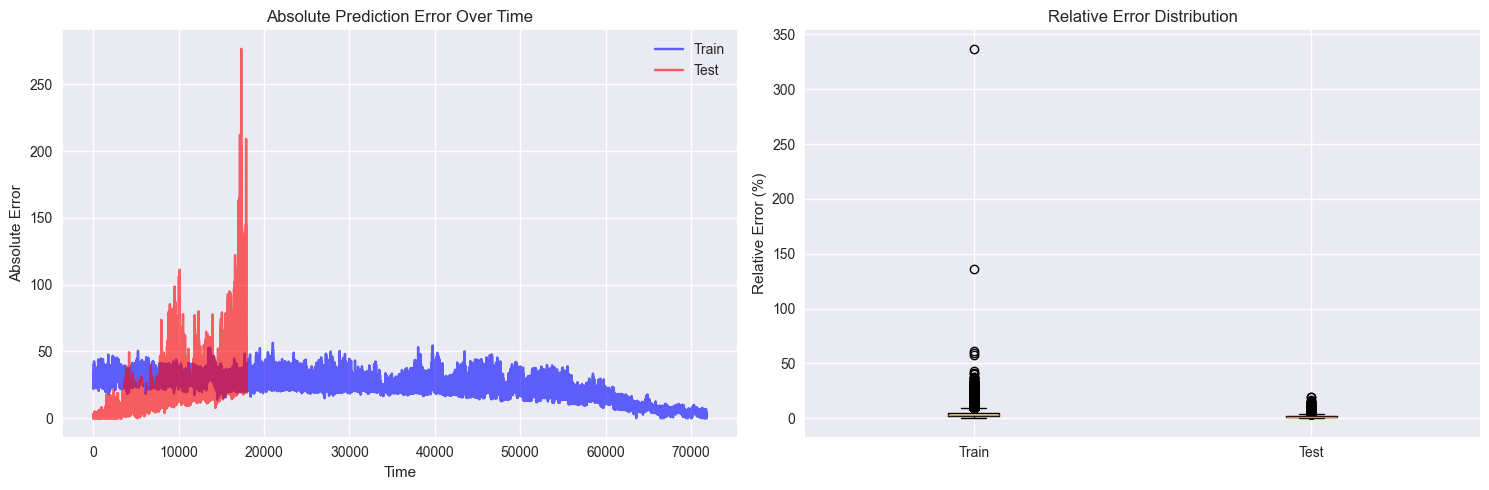

In [22]:
# 추가적인 성능 지표 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 5. 시간에 따른 예측 오차
ax1.plot(np.abs(train_errors), label='Train', alpha=0.6, color='blue')
ax1.plot(np.abs(test_errors), label='Test', alpha=0.6, color='red')
ax1.set_title('Absolute Prediction Error Over Time')
ax1.set_ylabel('Absolute Error')
ax1.set_xlabel('Time')
ax1.legend()

# 6. 상대 오차 박스플롯
train_relative_error = np.abs(train_errors) / train_y_true * 100
test_relative_error = np.abs(test_errors) / test_y_true * 100
data = [train_relative_error, test_relative_error]
ax2.boxplot(data, labels=['Train', 'Test'])
ax2.set_title('Relative Error Distribution')
ax2.set_ylabel('Relative Error (%)')

plt.tight_layout()
plt.show()

- **절대 예측 오차 (Absolute Prediction Error Over Time)**:
  - **학습 데이터 (파란색)**: 0~50 사이의 비교적 안정적인 오차 범위 유지
  - **테스트 데이터 (빨간색)**: 10000~20000 구간에서 최대 250까지의 큰 오차 발생
  - 전반적으로 시간이 지날수록 오차가 감소하는 경향

- **상대 오차 분포 (Relative Error Distribution)**:
  - **학습 데이터**: 대부분 0~50% 사이에 분포하며, 일부 이상치가 350%까지 발생
  - **테스트 데이터**: 학습 데이터보다 좁은 범위의 오차 분포를 보이며, 박스플롯에서 테스트 데이터의 중앙값이 더 낮음


### LSTM 모델 평가
- 전반적인 패턴 예측이 안정적
- 과적합 없이 일반화

##### 한계점
- 급격한 변동예측에서 큰 오차
- 전반적으로 실제값보다 낮게 예측

##### 개선사항
- Bidirectional LSTM 사용으로 양방향 문맥 고려
- 다른 모델과의 비교

### 예측 내용 분석
- **학습 데이터 패턴**:
  - 전반적으로 우상향하는 추세를 보임
  - 초기 0~200 수준에서 시작하여 후반부에는 2000~2500 수준까지 상승
  - 시간이 지날수록 변동폭이 점차 커지는 특징
  - 약 70000 시점 근처에서 급격히 하락 후 반등하는 패턴

- **테스트 데이터 패턴**:
  - 500~3500 사이에서 큰 폭의 변동을 보임
  - 전체적으로 높은 수준 (1500~2500)을 유지
  - 초반부에 변동성이 크고, 중반 이후 비교적 안정적인 패턴 유지
  - 마지막 구간 (15000~17500)에서 상승세와 함께 변동성 증가
